# Assignment 5

## Problem 1 [20 Points]

Consider the following functions which are indexed by increasing levels of fidelity:

$$f_3(x) = \left(\frac{-1.275 x_1^2}{\pi^2} + \frac{5x_1}{\pi} + x_2 - 6 \right)^2 + \left(10 - \frac{5}{4 \pi}\right) \cos(x_1) + 10,$$
$$f_2(x) = 10 \sqrt{f_3(x - 2)} + 2(x_1 - 0.5) - 3(3x_2 - 1) - 1$$
$$f_1(x) = f_2(1.2(x + 2)) - 3x_2 + 1.$$

Given a set of noiseless multi-fidelity observations of $f_1$, $f_2$ and $f_3$,  train a multi-fidelity GP that can approximate the highest fidelity function $f_3$. Considering $n_1 = 80, n_2 = 40, n_3 = 20$ observations for each of the functions, obtained by randomly sampling in $[-5, 10] \times [0, 15]$, find the relative $\mathbb{L}_2$ error of the high-fidelty function on a test-grid. Report your performance over 100 different trials.


##Mathematical model:
For x ϵ $ℝ^{2}$, y ϵ $ℝ$ the noiseless observations are modeled as : 

\begin{align}
  y_1 = f_1(x) \\
  y_2 = f_2(x) \\
  y_3 = f_3(x)
\end{align}

where:
\begin{align}
  f_1(x) ∼ \text{GP} (0,K_1(x,x',θ_1)) \\
  f_2(x) \sim c_1f_1(x) + ϵ_2(x) \\
  f_3(x) \sim c_2f_2(x) + ϵ_3(x) 
\end{align}
where:
\begin{align}
  ϵ_2(x) \sim \text{GP} (0,K_2(x,x',θ_2)) \\
  ϵ_3(x) \sim \text{GP} (0,K_3(x,x',θ_3)) \\
\end{align}

##Training phase :

Given $\mathcal{D}$ = {$x_1,y_1$}, {$x_2,y_2$}, {$x_3,y_3$}  :
\begin{align}
p(y_1,y_2,y_3) = \mathcal{N}\left(\begin{bmatrix}0\\0\\0 \end{bmatrix}, \begin{bmatrix} K_{11}(x_1,x_1) \ \ \ K_{12}(x_1,x_2) \ \ \ K_{13}(x_1,x_3)\\ K_{12}^T(x_1,x_2) \ \  \ K_{22}(x_2,x_2) \ \ \  K_{23}(x_2,x_3)\\ K_{13}^T (x_1,x_3) \ \  \ K_{23}^T(x_2,x_3) \ \ \  K_{33}(x_3,x_3) \end{bmatrix}\right)
\end{align}

where:
\begin{align}
K_{11}=K_1 \\
K_{22}=c_1K_1\\
K_{13}= 0\\
K_{22}=c_1^2K_1+K_2\\
K_{23}=c_2(c_1^2K_1+K_2)\\
K_{33}=c_2^2(c_1^2K_1+K_2)+K_3
\end{align}

##Prediction phase:

Given  $x^*$ the joint posterior will be :

\begin{align}
p\left(\begin{bmatrix}f(x^*) \\ y_1 \\ y_2\\ y_3 \end{bmatrix}\right) = \mathcal{N}\left(\begin{bmatrix}0 \\ 0\\ 0 \\ 0 \end{bmatrix},\begin{bmatrix} K_{33}(x^*,x_1) \ \ \ K_{13}(x^*,x_1) \ \ \ K_{23}(x^* ,x_2) \ \ \ K_{33}(x^* ,x_3)\\ \ \ \ \ \ \ \ \ \ \ \ \huge{κ} \end{bmatrix}\right)
\end{align}

In [ ]:
# your code here
!pip install --upgrade PyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for PyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=4cd6a3451f33e78e99edfe48cca75c1d6700fe9545fdadb77474cca8e08b7eab
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built PyDOE


In [ ]:
import jax.numpy as np
import numpy as onp
from jax import vmap, jit, vjp, random
from jax.scipy.linalg import cholesky, solve_triangular

from jax.config import config
config.update("jax_enable_x64", True)

from pyDOE import lhs
from functools import partial
from tqdm import trange
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rc

onp.random.seed(1234)

In [ ]:
def RBF(x1, x2, params):
    output_scale = params[0]
    lengthscales = params[1:]
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

In [ ]:
def minimize_lbfgs(objective, x0, bnds = None):
    result = minimize(objective, x0, jac=True,
                      method='L-BFGS-B', bounds = bnds,
                      callback=None)
    return result.x, result.fun

In [ ]:
class GPRegression:
    # Initialize the class
    def __init__(self, kernel_fn = RBF): 
        self.kernel = kernel_fn
                              
    def random_init_GP(self, rng_key, dim):
        key1,key2=random.split(rng_key,2)

        hyp = np.concatenate([np.log(random.uniform(key1,(9,))),random.uniform(key2,(2,))])
        return hyp

    def compute_cholesky(self, params, batch):
        X1,X2,X3, _ = batch
        # Fetch params
        theta1 = np.exp(params[:(dim+1)])
        theta2=np.exp(params[(dim+1):2*(dim+1)])
        theta3=np.exp(params[2*(dim+1):3*(dim+1)])
        c1,c2=params[3*(dim+1):]
        #Form block matrices
        k11=self.kernel(X1,X1,theta1)
        k12=c1*self.kernel(X1,X2, theta1)
        k13=np.zeros((X1.shape[0],X3.shape[0]))
        k22=c1**2*self.kernel(X2,X2,theta1)+self.kernel(X2,X2,theta2)
        k23=c2*(c1**2*self.kernel(X2,X3,theta1)+self.kernel(X2,X3,theta2))
        k33=c2**2*(c1**2*self.kernel(X3,X3,theta1)+self.kernel(X3,X3,theta2))+ \
                           self.kernel(X3,X3,theta3)
        K=np.vstack((np.hstack((k11, k12,k13)),
               np.hstack((k12.T,k22, k23)),
               np.hstack((k13.T,k23.T,k33)))) +10**(-14)

        # Compute kernel
        L = cholesky(K, lower=True)
        return L

    def likelihood(self, params, batch):
        _,_,_, y = batch
        N = y.shape[0]
        # Compute Cholesky
        L = self.compute_cholesky(params, batch)
        # Compute negative log-marginal likelihood
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        NLML = 0.5*np.matmul(np.transpose(y),alpha) + \
               np.sum(np.log(np.diag(L))) + 0.5*N*np.log(2.0*np.pi)
        return NLML

    @partial(jit, static_argnums=(0,))
    def likelihood_value_and_grad(self, params, batch):
        fun = lambda params: self.likelihood(params, batch)
        primals, f_vjp = vjp(fun, params)
        grads = f_vjp(np.ones_like(primals))[0]
        return primals, grads

    def train(self, batch, rng_key, num_restarts = 10):
        # Define objective that returns NumPy arrays (to be minimized with SciPy)
        def objective(params):
            value, grads = self.likelihood_value_and_grad(params, batch)
            out = (onp.array(value), onp.array(grads))
            return out
        # Optimize with random restarts
        params = []
        likelihood = []
        rng_key = random.split(rng_key, num_restarts)
        for i in trange(num_restarts):
            init = self.random_init_GP(rng_key[i], dim)
            p, val = minimize_lbfgs(objective, init)
            params.append(p)
            likelihood.append(val)
        params = np.vstack(params)
        likelihood = np.vstack(likelihood)
        #### find the best likelihood (excluding any NaNs) ####
        bestlikelihood = np.nanmin(likelihood)
        idx_best = np.where(likelihood == bestlikelihood)
        idx_best = idx_best[0][0]
        best_params = params[idx_best,:]
        return best_params

    @partial(jit, static_argnums=(0,))
    def predict(self, params, batch, X_star):
        X1,X2,X3, y = batch
        # Fetch params
        theta1 = np.exp(params[:(dim+1)])
        theta2=np.exp(params[(dim+1):2*(dim+1)])
        theta3=np.exp(params[2*(dim+1):3*(dim+1)])
        c1,c2=params[3*(dim+1):]
        # Compute kernels
        k13_p=np.zeros((X_star.shape[0],X1.shape[0]))
        k23_p=c2*(c1**2*self.kernel(X_star,X2,theta1)+self.kernel(X_star,X2,theta2))
        k33_p=c2**2*(c1**2*self.kernel(X_star,X3,theta1)+self.kernel(X_star,X3,theta2))+ \
                          self.kernel(X_star,X3,theta3)
        k_pp=c2**2*(c1**2*self.kernel(X_star,X_star,theta1)+self.kernel(X_star,X_star,theta2))+ \
                           self.kernel(X_star,X_star,theta3)

       
        k_pX=np.hstack((k13_p,k23_p,k33_p))
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        std = np.sqrt(np.clip(np.diag(cov), a_min=0.))
        return mu, std

    @partial(jit, static_argnums=(0,))
    def draw_posterior_sample(self, rng_key, params, batch, X_star):
        X1,X2,X3, y = batch
        # Fetch params
        theta1 = np.exp(params[:(dim+1)])
        theta2=np.exp(params[(dim+1):2*(dim+1)])
        theta3=np.exp(params[2*(dim+1):3*(dim+1)])
        c1,c2=params[3*(dim+1):]
        # Compute kernels
        k13_p=np.zeros((X_star.shape[0],X1.shape[0]))
        k23_p=c2*(c1**2*self.kernel(X_star,X2,theta1)+self.kernel(X_star,X2,theta2))
        k33_p=c2**2*(c1**2*self.kernel(X_star,X3,theta1)+self.kernel(X_star,X3,theta2))+ \
                          self.kernel(X_star,X3,theta3)
        k_pp=c2**2*(c1**2*self.kernel(X_star,X_star,theta1)+self.kernel(X_star,X_star,theta2))+ \
                           self.kernel(X_star,X_star,theta3)

       
        k_pX=np.hstack((k13_p,k23_p,k33_p))
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        sample = random.multivariate_normal(rng_key, mu, cov)
        return sample  

In [ ]:
f3 = lambda x:(-1.275*x[0]**2/np.pi**2+5*x[0]/np.pi+x[1]-6)**2+(10-5/4/np.pi)*np.cos(x[0])+10
f2 = lambda x:10*np.sqrt(f3(x - 2))+2*(x[0]-0.5)-3*(3*x[1]-1)-1
f1 = lambda x:f2(1.2*(x+2))-3*x[1]+1

In [ ]:
N1 = 80
N2=40
N3=20
dim = 2
noise = 0.0
lb = np.array([-5.0,10.0])
ub = np.array([0.0,15.0])

# Training data
X1 = lb + (ub-lb)*lhs(dim, N1,criterion='center')
X2 = lb + (ub-lb)*lhs(dim, N2,criterion='center')
X3 = lb + (ub-lb)*lhs(dim, N3,criterion='center')
y1 = vmap(f1)(X1)
y2 = vmap(f2)(X2)
y3 = vmap(f3)(X3)
y=np.concatenate([y1,y2,y3])
# Test data
n_star = 1000
X_star = lb + (ub-lb)*lhs(dim, n_star,criterion='center')
y_star = vmap(f3)(X_star)

In [ ]:
model = GPRegression(kernel_fn = RBF)

In [ ]:
mu_y, sigma_y = y.mean(0), y.std(0)
X_train1 = (X1 - lb)/(ub-lb)
X_train2 = (X2 - lb)/(ub-lb)
X_train3 = (X3 - lb)/(ub-lb)
y_train = (y - mu_y)/sigma_y

# Train model
train_key = random.PRNGKey(0)
opt_params = model.train((X_train1,X_train2,X_train3, y_train), train_key, num_restarts = 100)

100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


In [ ]:
X_test = (X_star - lb)/(ub-lb)

# Make predictions
mean, std = model.predict(opt_params, (X_train1,X_train2,X_train3, y_train), X_test)

# De-normalize predictions
mean, std = mean*sigma_y + mu_y, std*sigma_y

# Uncertainty bands
lower = mean - 2.0*std
upper = mean + 2.0*std

# Draw posterior samples
num_draws = 10
test_keys = random.split(random.PRNGKey(0), num_draws)
sample_fn = lambda key: model.draw_posterior_sample(key, opt_params, (X_train1,X_train2,X_train3, y_train), X_test)
f_samples = vmap(sample_fn)(test_keys)
f_samples = f_samples*sigma_y + mu_y

# Check accuracy
error = np.linalg.norm(mean-y_star,2)/np.linalg.norm(y_star,2)
print("Relative L2 error for f3 on test grid: %e" % (error))

Relative L2 error for f3 on test grid: 3.659891e-04



## Problem 2 [20 Points]

i) Consider the following definitions for a kernel $K(x, x')$:
- Definition A: $K(x, x')$ is valid if there exist a mapping function $\phi(x)$ that $K(x, x') = \phi(x)^T \phi(x')$
- Definition B: $K(x, x')$ is valid if for any finite set of training examples $x_1, \cdots, x_n$, the matrix $K$ with elements defined as $K_{ij} = K(x_i, x_j)$ is positive semidefinite.

Show that Definition A $\implies$ Definition B. Would $K(x, x') = \tanh(x\cdot x' - 1)$ be a valid kernel?

ii) One way to build valid kernels is by constructing them from simpler kernel functions: assuming $K_1(x, x')$ and $K_2(x, x')$ are kernels
- Scaling: $f(x) K(x, x') f(x')$
- Sum: $K_1(x, x') + K_2(x, x')$
- Product: $K_1(x, x') K_2(x, x')$

Prove that these operations result in a valid kernel function. Do note that the feature vectors of different kernels may be of different length.

iii) Using kernels $K_0(x, x') = 1$ and $K_1(x, x') = x^T x'$ propose steps to arrive at the kernel using the earlier steps:

$$K(x, x') = \left(1 + \left(\frac{x}{\|x\|}\right)^T \left(\frac{x'}{\|x'\|}\right)\right)^3$$


1)If definition A is true:
$$
K(x, x')=\Phi^T\Phi(x')\\
$$
consider  the matrix $$K_{ij}=\Phi(x_{i})^T\Phi(x_{j}) $$
The above matrix is symmetric i.e
$$K_{ji} =\Phi(x_{j})^T\Phi(x_{i})=\Phi(x_{i})^T\Phi(x_{j})=K_{ij}$$\
$$∑ C_{i}C_{j} K_{ij}=∑C_{i}C_{j}Φ(x_{i})^TΦ(x_{j})$$\
                     $$=∑C_{i}Φ(x_{i})^T∑C_{j}Φ(x_{j})$$\
                     $$=(∑C_{i}Φ(x_{i}))^T(∑C_{j}\phi(x_{j}))$$\
                     $$||∑C_{i}Φ(x_{i})||^2 \geq 0$$
K(x,x')=tanh(x.x'-1) would not be a valid kernel since the gram matrix that will form will not be positive semi-definite.Therefore violating the definition.




2) If $K_{1}(x,x')$ and $K_{2}(x,x')$ are kernels.

Scaling:

$K_{1}(x,x')=Φ_{1}(x)^TΦ_{1}(x')$

f(x)$K_{1}(x,x')$f(x')=f(x)$Φ_{1}(x)^TΦ_{1}(x')^T$f(x')

$[\phi_{1}(x)f(x)]^T[\phi_{1}(x')f(x')]$

Hence by definition A this is a kernel.

Sum:

Consider the gram matrix $K(x_{i},x{j})=K_{1}(x_{i},x{j})+K_{2}(x_{i},x_{j})$
Since $K_{1}(x_{i},x{j}) and K_{2}(x_{i},x_{j}),K(x_{i},x{j})$ is symmetric.

Since $K_{1}(x_{i},x{j}) and K_{2}(x_{i},x_{j}),K(x_{i},x{j})$ are positive semi-definite.$K(x_{i},x{j})$ is also positive semi-definite.

So, $K_{1}(x,x')+K_{2}(x,x')$ is a valid kernel function.


Product:

Consider the gram matrix $K_{ij}=K_{1}(x_{i},x{j})K_{2}(x_{i},x{j})$
Since $K_{1}(x_{i},x{j})$ and $K_{2}(x_{i},x{j})$ are symmetric:
$K_{ji}=K_{1}(x_{j},x_{i})K_{2}(x_{j},x_{i})$\
        $=K_{1}(x_{i},x_{j})K_{2}(x_{i},x_{j})$\
$=K_{ij}$\
Hence $K_{ij}$ is symmetric 

Since $K_{1}(x_{i},x{j})$ and $K_{2}(x_{i},x{j})$ are positive definite.\
$K_{ij}=K_{1}(x_{i},x_{j})K_{2}(x_{i},x_{j})$ is also positive  definite by "schur" product theorem.


3)\
Scale $K_{1}(x,x')$ with $$f(x)=\left(\frac{x}{\|x\|}\right)^T \left(\frac{x'}{\|x'\|}\right)$$

Add k_{0}(x,x')=1 to the kernel obtained in the previous step to get 
$$\left(1 + \left(\frac{x}{\|x\|}\right)^T \left(\frac{x'}{\|x'\|}\right)\right)$$

Multiply the kernel obtained in step 3 by itself thrice to get  $$K(x, x') = \left(1 + \left(\frac{x}{\|x\|}\right)^T \left(\frac{x'}{\|x'\|}\right)\right)^3$$



## Problem 3 [20 Points]
Consider the Helmholtz equation in one dimension:

$$\frac{\partial^{2}}{\partial{x}^2}u(x) - \gamma u(x) = f(x), \ \ x\in[-1,1].$$

The exact solution for this problem is $u(x) = \sin(\pi x)$, corresponding to $f(x) = -\pi^2 \sin(\pi x) - \gamma \sin(\pi x)$. First, consider $\gamma = 5\sqrt{2}$ and generate a training data-set $\{X_u,y_u\}$ and $\{X_f,y_f\}$ by sampling the exact solution for $u(x)$ and $f(x)$, respectively. Specifically, use $N_u=3$ and $N_f=10$ data points sampled randomly on a Latin Hypercube grid.

Then use this data-set to train the following Gaussian process model in order to predict the underlying functions $u(x)$ and $f(x)$, as well as to learn the unknown parameter $\gamma$:

$u(x)\sim\mathcal{GP}(0, k(x,x', \theta)), \qquad f(x)\sim\mathcal{GP}(0, g(x,x';\theta, \gamma))$,

where $g(x,x';\theta, \gamma) = \mathcal{L}_{x}^{\gamma}\mathcal{L}^{\gamma}_{x'}k(x,x';\theta)$, $\mathcal{L}_{x}^{\gamma}:= \frac{\partial^{2}}{\partial{x}^2} - \gamma$, and  $k(x,x';\theta)$ is the standard RBF kernel. Use symbolic calculations to construct the necessary kernels and note how $\gamma$ becomes a kernel hyper-parameter for  $g(x,x';\theta, \gamma)$ ([reference](https://www.sciencedirect.com/science/article/pii/S0021999117305582)). Plot your predictions for $u(x)$ and $f(x)$ against the exact solution, and report their relative error in the $\mathbb{L}_2$ norm. Also report the predicted value for $\gamma$ and the corresponding %-error with respect to the exact value of $5\sqrt{2}$.


In [ ]:
# your code here!
!pip install git+https://github.com/paraklas/sympy2jax.git
!pip install --upgrade PyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paraklas/sympy2jax.git to /tmp/pip-req-build-7wbwkv76
  Running command git clone --filter=blob:none --quiet https://github.com/paraklas/sympy2jax.git /tmp/pip-req-build-7wbwkv76
  Resolved https://github.com/paraklas/sympy2jax.git to commit fb4bbbf4ab065c6db488cdb62ed262a42fb8f91c
  Preparing metadata (setup.py) ... done
  Created wheel for sympy2jax: filename=sympy2jax-0.1.0-py3-none-any.whl size=8882 sha256=0aa7511a25f3eeb573a7221484acc8094a6a095fe598499ebc79cbed31dd9a62
  Stored in directory: /tmp/pip-ephem-wheel-cache-imt5apqg/wheels/fb/a5/4f/c148733c389fd19ecfb685abf46d9dd2c522e1857585f05c4c
Successfully built sympy2jax
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import jax.numpy as np
from jax import random, vmap, jit, jvp
from jax.scipy.linalg import cholesky, solve_triangular
from jax.config import config
config.update("jax_enable_x64", True)

import sympy as sp
from sympy2jax import sympy2jax
import matplotlib.pyplot as plt

import jax.numpy as np
import numpy as onp
from jax import vmap, jit, vjp, random
from jax.scipy.linalg import cholesky, solve_triangular

from jax.config import config
config.update("jax_enable_x64", True)

from pyDOE import lhs
from functools import partial
from tqdm import trange
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rc

onp.random.seed(1234)

In [ ]:
def operator(k, x):
    return sp.Derivative(k, x)

In [ ]:
x, xp = sp.symbols('x xp')
sigma, ell,gamma = sp.symbols('sigma ell,gamma')

k_uu = sp.simplify(sigma*sp.exp(-0.5*(sp.Pow((x-xp)/ell,2))))
k_uf = sp.simplify(operator(k_uu, xp)-gamma*k_uu)
k_fu=sp.simplify(operator(k_uu, x)-gamma*k_uu)
k_ff = sp.simplify(operator(k_uf,x)-gamma*k_uf)

In [ ]:
k_uu_fn, k_uu_params = sympy2jax(k_uu, [x, xp, sigma, ell])
k_uf_fn, k_uf_params = sympy2jax(k_uf, [x, xp, sigma, ell,gamma])
k_fu_fn, k_fu_params = sympy2jax(k_fu, [x, xp, sigma, ell,gamma])
k_ff_fn, k_ff_params = sympy2jax(k_ff, [x, xp, sigma, ell,gamma])

In [ ]:
def _k_uu(params, x, xp):
    sigma = params[0:1]
    ell = params[1:2]
    inputs = np.concatenate([x, xp, sigma, ell]).reshape(1,4)
    return k_uu_fn(inputs, k_uu_params)[0]
    
def _k_uf(params, x, xp):
    sigma = params[0:1]
    ell = params[1:2]
    gamma=params[2:3]
    inputs = np.concatenate([x, xp, sigma, ell,gamma]).reshape(1,5)
    return k_uf_fn(inputs, k_uf_params)[0]
    
def _k_fu(params, x, xp):
    sigma = params[0:1]
    ell = params[1:2]
    gamma=params[2:3]
    inputs = np.concatenate([x, xp, sigma, ell,gamma]).reshape(1,5)
    return k_fu_fn(inputs, k_fu_params)[0]

def _k_ff(params, x, xp):
    sigma = params[0:1]
    ell = params[1:2]
    gamma=params[2:3]
    inputs = np.concatenate([x, xp, sigma, ell,gamma]).reshape(1,5)
    return k_ff_fn(inputs, k_ff_params)[0]

In [ ]:
def vectorize(kernel):
    vec_fun = vmap(vmap(kernel, in_axes=(None,None,0)), in_axes=(None,0,None))
    return vec_fun


k_uu_vec = jit(vectorize(_k_uu))
k_uf_vec = jit(vectorize(_k_uf))
k_fu_vec = jit(vectorize(_k_fu))
k_ff_vec = jit(vectorize(_k_ff))

In [ ]:
def minimize_lbfgs(objective, x0, bnds = None):
    result = minimize(objective, x0, jac=True,
                      method='L-BFGS-B', bounds = bnds,
                      callback=None)
    return result.x, result.fun

In [ ]:
class GPRegression:
    # Initialize the class
    def __init__(self, K1 = k_uu_vec,K2=k_uf_vec,K3=k_ff_vec,K4=k_fu_vec): 
        self.kuu = K1
        self.kuf = K2
        self.kff = K3
        self.kfu = K4
                              
    def random_init_GP(self, rng_key, dim):
        hyp = np.log(10*random.uniform(rng_key,(2+dim,))+1e-8)
        return hyp


    def compute_cholesky(self, params, batch):
        Xu,Xf,_= batch
        # Compute kernel
        kuu=self.kuu(np.exp(params[:-1]),Xu,Xu)
        kuf=self.kuf(np.exp(params),Xu,Xf)
        kff=self.kff(np.exp(params),Xf,Xf)
        K=np.vstack((np.hstack((kuu, kuf)),
               np.hstack((kuf.T, kff))))
        K=K+10**-8*np.eye(np.shape(K)[0])
        L = cholesky(K, lower=True)
        return L

    def likelihood(self, params, batch):
        _,_, y = batch
        N = y.shape[0]
        # Compute Cholesky
        L = self.compute_cholesky(params, batch)
        # Compute negative log-marginal likelihood
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        NLML = 0.5*np.matmul(np.transpose(y),alpha) + \
               np.sum(np.log(np.diag(L))) + 0.5*N*np.log(2.0*np.pi)
        return NLML

    @partial(jit, static_argnums=(0,))
    def likelihood_value_and_grad(self, params, batch):
        fun = lambda params: self.likelihood(params, batch)
        primals, f_vjp = vjp(fun, params)
        grads = f_vjp(np.ones_like(primals))[0]
        return primals, grads

    def train(self, batch, rng_key, num_restarts = 10):
        # Define objective that returns NumPy arrays (to be minimized with SciPy)
        def objective(params):
            value, grads = self.likelihood_value_and_grad(params, batch)
            out = (onp.array(value), onp.array(grads))
            return out
        # Optimize with random restarts
        params = []
        likelihood = []
        rng_key = random.split(rng_key, num_restarts)
        for i in trange(num_restarts):
            init = self.random_init_GP(rng_key[i], dim)
            p, val = minimize_lbfgs(objective, init)
            params.append(p)
            likelihood.append(val)
        params = np.vstack(params)
        likelihood = np.vstack(likelihood)
        #### find the best likelihood (excluding any NaNs) ####
        #### find the best likelihood (excluding any NaNs) ####
        bestlikelihood = np.nanmin(likelihood)
        idx_best = np.where(likelihood == bestlikelihood)
        idx_best = idx_best[0][0]
        best_params = params[idx_best,:]
        return best_params

    @partial(jit, static_argnums=(0,))
    def predict1(self, params, batch, X_star):
        Xu,Xf, y = batch
        # Compute kernels
        k_pp=self.kuu(np.exp(params[:-1]),X_star,X_star)
        k1=self.kuu(np.exp(params),X_star,Xu)
        k2=self.kuf(np.exp(params),X_star,Xf)
        k_pX=np.hstack((k1,k2))
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean
        mu = np.matmul(k_pX, alpha)[:,0]
        cov = k_pp - np.matmul(k_pX, beta)
        std = np.sqrt(np.clip(np.diag(cov), a_min=0.))
        return mu, std

    @partial(jit, static_argnums=(0,))
    def draw_posterior1(self, rng_key, params, batch, X_star):
        Xu,Xf, y = batch
        # Compute kernels
        k_pp=self.kuu(np.exp(params[:-1]),X_star,X_star)
        k1=self.kuu(np.exp(params),X_star,Xu)
        k2=self.kuf(np.exp(params),X_star,Xf)
        k_pX=np.hstack((k1,k2))
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean
        mu = np.matmul(k_pX, alpha)[:,0]
        cov = k_pp - np.matmul(k_pX, beta)
        sample = random.multivariate_normal(rng_key, mu, cov)
        return sample   

    @partial(jit, static_argnums=(0,))
    def predict2(self, params, batch, X_star):
        Xu,Xf, y = batch
        # Compute kernels
        k_pp=self.kff(np.exp(params),X_star,X_star)
        k1=self.kfu(np.exp(params),X_star,Xu)
        k2=self.kff(np.exp(params),X_star,Xf)
        k_pX=np.hstack((k1,k2))
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean
        mu = np.matmul(k_pX, alpha)[:,0]
        cov = k_pp - np.matmul(k_pX, beta)
        std = np.sqrt(np.clip(np.diag(cov), a_min=0.))
        return mu, std

    @partial(jit, static_argnums=(0,))
    def draw_posterior2(self, rng_key, params, batch, X_star):
        Xu,Xf, y = batch
        # Compute kernels
        k_pp=self.kff(np.exp(params),X_star,X_star)
        k1=self.kfu(np.exp(params),X_star,Xu)
        k2=self.kff(np.exp(params),X_star,Xf)
        k_pX=np.hstack((k1,k2))
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean
        mu = np.matmul(k_pX, alpha)[:,0]
        cov = k_pp - np.matmul(k_pX, beta)
        sample = random.multivariate_normal(rng_key, mu, cov)
        return sample   

In [ ]:
u = lambda x: np.sin(np.pi * x)
f = lambda x, gamma: -(np.pi ** 2 + gamma) * np.sin(np.pi * x)



Nu = 3
Nf=10
dim = 1
noise = 0.0
lb = np.array([-1.0,-1.0])
ub = np.array([1.0,1.0])
gamma=5*2**(0.5)

# Training data
Xu = lb[0] + (ub[0]-lb[0])*lhs(dim, Nu,criterion='center')
Xf = lb[1] + (ub[1]-lb[1])*lhs(dim, Nf,criterion='center')
yu = u(Xu)
yf = vmap(f,in_axes=(0,None))(Xf,gamma)

# Test data
n_star = 50
X_star = np.linspace(lb[0], ub[0], n_star)[:,None]
u_star = vmap(u)(X_star)
f_star = vmap(f,in_axes=(0,None))(X_star,gamma)
y_train=np.concatenate([yu,yf])


In [ ]:
model = GPRegression()

In [ ]:
Xu_train = (Xu-lb[0])/(ub[0]-lb[0])
Xf_train = (Xf-lb[1])/(ub[1]-lb[1])

mu_y,sigma_y=y_train.mean(0),y_train.std(0)

y_train=(y_train-mu_y)/sigma_y

# Train model
train_key = random.PRNGKey(0)
opt_params = model.train((Xu_train,Xf_train, y_train), train_key, num_restarts = 100)

100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


In [ ]:
X_test = (X_star-lb[0])/(ub[0]-lb[0])

# Make predictions
mean, std = model.predict1(opt_params, (Xu_train,Xf_train, y_train), X_test)

# De-normalize predictions
mean, std = mean*sigma_y + mu_y, std*sigma_y

# Uncertainty bands
lower = mean - 2.0*std
upper = mean + 2.0*std

# Draw posterior samples
num_draws = 10
test_keys = random.split(random.PRNGKey(0), num_draws)
sample_fn = lambda key: model.draw_posterior1(key, opt_params,  (Xu_train,Xf_train, y_train), X_test)
f_samples = vmap(sample_fn)(test_keys)
f_samples = f_samples*sigma_y + mu_y

# Check accuracy
error = np.linalg.norm(mean-u_star[:,0],2)/np.linalg.norm(u_star[:,0],2)
print("Relative L2 error u: %e" % (error))

Relative L2 error u: 3.408395e-01


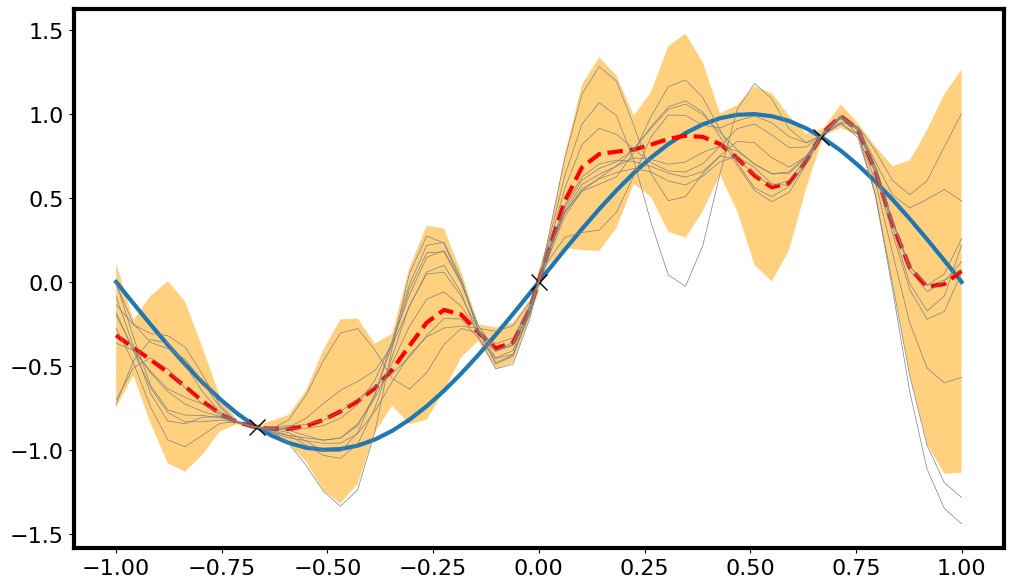

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3

plt.figure(figsize = (12,7))
plt.plot(X_star, u_star, lw = 3)
plt.plot(X_star, mean, 'r--', lw = 3)
plt.plot(Xu, yu, 'kx', ms = 12)
plt.fill_between(X_star.flatten(), lower.flatten(), upper.flatten(), 
                  facecolor='orange', alpha=0.5, label="Two std band")
for i in range(num_draws):
     plt.plot(X_star, f_samples[i,:], '-', color='gray', lw = 0.5)

In [ ]:
mean, std = model.predict2(opt_params, (Xu_train,Xf_train, y_train), X_test)

# De-normalize predictions
mean, std = mean*sigma_y + mu_y, std*sigma_y

# Uncertainty bands
lower = mean - 2.0*std
upper = mean + 2.0*std

# Draw posterior samples
num_draws = 10
test_keys = random.split(random.PRNGKey(0), num_draws)
sample_fn = lambda key: model.draw_posterior2(key, opt_params,  (Xu_train,Xf_train, y_train), X_test)
f_samples = vmap(sample_fn)(test_keys)
f_samples = f_samples*sigma_y + mu_y

# Check accuracy
error = np.linalg.norm(mean-f_star[:,0],2)/np.linalg.norm(f_star[:,0],2)
print("Relative L2 error f: %e" % (error))

Relative L2 error f: 5.109941e-01


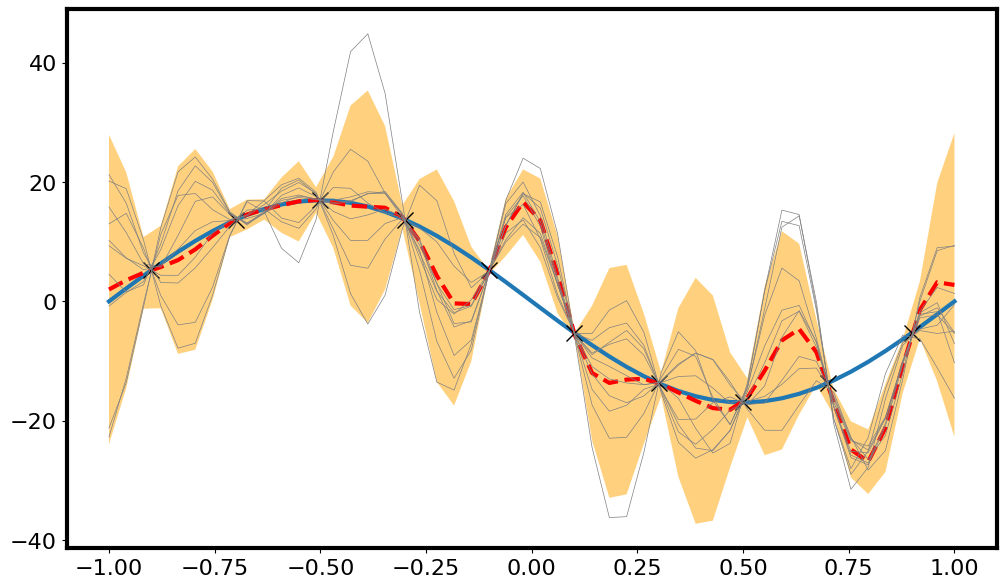

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3

plt.figure(figsize = (12,7))
plt.plot(X_star, f_star, lw = 3)
plt.plot(X_star, mean, 'r--', lw = 3)
plt.plot(Xf, yf, 'kx', ms = 12)
plt.fill_between(X_star.flatten(), lower.flatten(), upper.flatten(), 
                  facecolor='orange', alpha=0.5, label="Two std band")
for i in range(num_draws):
   plt.plot(X_star, f_samples[i,:], '-', color='gray', lw = 0.5)

In [ ]:
gamma_pred=np.exp(opt_params[-1])
error=(gamma_pred-gamma)/gamma*100
print("Predicted value of gamma = ",gamma_pred)
print("Error in gamma = ",error,"%")


Predicted value of gamma =  17.977440263687587
Error in gamma =  154.23939837659134 %


The mean of the posterior predictions for u and f match well with the true curves.

However, the value of $γ$ predicted has a large error. This could be due to lower number of samples used for training. This should improve if we train on higher number of samples.

## Problem 4 [20 Points]

Modify the provided [active learning tutorial](https://github.com/PredictiveIntelligenceLab/ENM531/blob/main/Notebooks/active_learning.ipynb) to implement a Bayesian optimization loop for minimizing the two-dimensional [Michalewicz  function](https://www.sfu.ca/~ssurjano/michal.html), using the following acquisition functions:

- Probability of Improvement:

$$\alpha(x;\mathcal{D}) := \Phi(f_{\text{min}}\lvert \mu(x), \Sigma(x))$$

- Expected Improvement:

$$\alpha(x;\mathcal{D}) := (f_{\text{min}} - \mu(x)) \Phi(f_{\text{min}}\lvert \mu(x), \Sigma(x)) + \Sigma(x) \mathcal{N}(f_{\text{min}}\lvert \mu(x), \Sigma(x))$$

- Upper Confidence Bound:

$$\alpha(x;\mathcal{D}) := \mu(x) + 2 \Sigma(x)$$

where $\mu(x)$ and $\Sigma(x)$ denotes the posterior mean and posterior standard deviation, respectively, of a Gaussian process model trained on a regression data-set $\mathcal{D}$. Compare the convergence of the different acquisition criteria by simulating each case over $25$ independent trials, starting from a randomized initial experimental design.

!pip install --upgrade PyDOE


In [ ]:
!pip install --upgrade PyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for PyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=952c65e0790bbeb5adddcd16b025d85a32f1cdce4bdaafcb80c4c3d004913bed
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built PyDOE


In [ ]:
import jax.numpy as np
import numpy as onp
import jax.scipy as jsp
from jax import vmap, jit, vjp, random
from jax.scipy.linalg import cholesky, solve_triangular

from jax.config import config
config.update("jax_enable_x64", True)

from pyDOE import lhs
from functools import partial
from tqdm import trange
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rc

onp.random.seed(1234)

In [ ]:
def RBF(x1, x2, params):
    output_scale = params[0]
    lengthscales = params[1:]
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

In [ ]:
def minimize_lbfgs(objective, x0, bnds = None):
    result = minimize(objective, x0, jac=True,
                      method='L-BFGS-B', bounds = bnds,
                      callback=None)
    return result.x, result.fun

In [ ]:
# A minimal Gaussian process class
class GPRegression:
    # Initialize the class
    def __init__(self, kernel_fn = RBF, acq_fn = None): 
        self.kernel = kernel_fn
        self.acq_fn = acq_fn
                              
    def random_init_GP(self, rng_key, dim):
        logsigma_f = np.log(50.0*random.uniform(rng_key, (1,)))
        loglength  = np.log(random.uniform(rng_key, (dim,)) + 1e-8)
        logsigma_n = np.array([-4.0]) + random.normal(rng_key, (1,))
        hyp = np.concatenate([logsigma_f, loglength, logsigma_n])
        return hyp

    def compute_cholesky(self, params, batch):
        X, _ = batch
        N, D = X.shape
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernel
        K = self.kernel(X, X, theta) + np.eye(N)*(sigma_n + 1e-8)
        L = cholesky(K, lower=True)
        return L

    def likelihood(self, params, batch):
        _, y = batch
        N = y.shape[0]
        # Compute Cholesky
        L = self.compute_cholesky(params, batch)
        # Compute negative log-marginal likelihood
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        NLML = 0.5*np.matmul(np.transpose(y),alpha) + \
               np.sum(np.log(np.diag(L))) + 0.5*N*np.log(2.0*np.pi)
        return NLML

    @partial(jit, static_argnums=(0,))
    def likelihood_value_and_grad(self, params, batch):
        fun = lambda params: self.likelihood(params, batch)
        primals, f_vjp = vjp(fun, params)
        grads = f_vjp(np.ones_like(primals))[0]
        return primals, grads

    def train(self, batch, rng_key, num_restarts = 10):
        # Define objective that returns NumPy arrays (to be minimized with SciPy)
        def objective(params):
            value, grads = self.likelihood_value_and_grad(params, batch)
            out = (onp.array(value), onp.array(grads))
            return out
        # Optimize with random restarts
        params = []
        likelihood = []
        X, _ = batch
        dim = X.shape[1]
        rng_key = random.split(rng_key, num_restarts)
        for i in trange(num_restarts):
            init = self.random_init_GP(rng_key[i], dim)
            p, val = minimize_lbfgs(objective, init)
            params.append(p)
            likelihood.append(val)
        params = np.vstack(params)
        likelihood = np.vstack(likelihood)
        #### find the best likelihood (excluding any NaNs) ####
        bestlikelihood = np.nanmin(likelihood)
        idx_best = np.where(likelihood == bestlikelihood)
        idx_best = idx_best[0][0]
        best_params = params[idx_best,:]
        return best_params

    @partial(jit, static_argnums=(0,))
    def predict(self, params, batch, X_star):
        X, y = batch
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernels
        k_pp = self.kernel(X_star, X_star, theta) + np.eye(X_star.shape[0])*(sigma_n + 1e-8)
        k_pX = self.kernel(X_star, X, theta)
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean, std
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        std = np.sqrt(np.clip(np.diag(cov), a_min=0.))
        return mu, std

    @partial(jit, static_argnums=(0,))
    def draw_posterior_sample(self, rng_key, params, batch, X_star):
        X, y = batch
        N, D = X.shape
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernels
        k_pp = self.kernel(X_star, X_star, theta) + np.eye(X_star.shape[0])*(sigma_n + 1e-8)
        k_pX = self.kernel(X_star, X, theta)
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        sample = random.multivariate_normal(rng_key, mu, cov)
        return sample    

    def acquisition(self, params, batch, x):
        x = x[None,:]
        _,y=batch
        mean, std = self.predict(params, batch, x)
        if self.acq_fn == 'LCB':
            return mean[0]-0.5*std[0]

        elif self.acq_fn == 'PI':
            fmin=np.min(y)
            theta=np.exp(params[:-1])
            sigma_n=np.exp(params[-1])
            k_xx=self.kernel(x,x,theta)+sigma_n   
            return -jsp.stats.norm.cdf(fmin,mean,k_xx)
        elif self.acq_fn == 'EI':
            fmin=np.min(y)
            theta=np.exp(params[:-1])
            sigma_n=np.exp(params[-1])
            k_xx=self.kernel(x,x,theta)+sigma_n  
            a=(fmin-mean)*jsp.stats.norm.cdf(fmin,mean,k_xx)
            b=k_xx*jsp.stats.norm.pdf(fmin,mean,k_xx)
            return -(a+b)            
        elif self.acq_fn == 'US':
            return -std[0]
        else:
            raise NotImplementedError

    @partial(jit, static_argnums=(0,))
    def acq_value_and_grad(self, params, batch, x):
        fun = lambda x: self.acquisition(params, batch, x)
        primals, f_vjp = vjp(fun, x)
        grads = f_vjp(np.ones_like(primals))[0]
        return primals, grads

    def next_best_point(self, params, batch, bounds, rng_key, num_restarts = 10):
        # Define objective that returns NumPy arrays
        def objective(x):
            x = (x - lb)/(ub-lb)
            value, grads = self.acq_value_and_grad(params, batch, x)
            out = (onp.array(value), onp.array(grads))
            return out
        # Optimize with random restarts
        loc = []
        acq = []
        lb, ub = bounds
        dim = lb.shape[0]
        onp.random.seed(rng_key[0])
        x0 = lb + (ub-lb)*lhs(dim, num_restarts,criterion='center')
        dom_bounds = tuple(map(tuple, np.vstack((lb, ub)).T))
        for i in trange(num_restarts):
            pos, val = minimize_lbfgs(objective, x0[i,:], bnds = dom_bounds)
            loc.append(pos)
            acq.append(val)
        loc = np.vstack(loc)
        acq = np.vstack(acq)
        idx_best = np.argmin(acq)
        x_new = loc[idx_best:idx_best+1,:]
        return x_new

In [ ]:

def branin():
    m=7
    dim = 2
    lb = np.array([0, 0])
    ub = np.array([np.pi, np.pi])
    def f(x):
        sum=0
        for i in range(dim):
          term=-np.sin(x[i])*(np.sin((i+1)*x[i]**2/np.pi))**(2*m)
          sum+=term
        return sum
    return f, dim, (lb, ub)

In [ ]:

# Define test function
f, dim, bounds = branin()

# Problem settings
N = 10
noise = 0.0
lb, ub = bounds

# Initial training data
X = lb + (ub-lb)*lhs(dim, N,criterion='center')
y = vmap(f)(X)

# Test data
nn = 80
xx = np.linspace(lb[0], ub[0], nn)
yy = np.linspace(lb[1], ub[1], nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], 
                          YY.flatten()[:,None]], axis = 1)
y_star = vmap(f)(X_star)

# Normalized test inputs
X_test = (X_star - lb)/(ub-lb)

In [ ]:

model = GPRegression(kernel_fn = RBF, acq_fn = 'LCB')

In [ ]:

# Active learning loop
num_iter = 50
error_log = []

for it in range(num_iter):
    print('\n')
    print('-------------------------------------------------------------------')
    print('------------------------- Iteration %d/%d -------------------------' % (it+1, num_iter))
    print('-------------------------------------------------------------------')

    # Normalize training data
    mu_y, sigma_y = y.mean(0), y.std(0)
    X_train = (X - lb)/(ub-lb)
    y_train = (y - mu_y)/sigma_y

    # Train model
    print('\nTrain GP...')
    train_key = random.PRNGKey(it)
    opt_params = model.train((X_train, y_train), train_key, num_restarts = 50)

    # Select next best point
    print('\nCompute next acquisition point...')
    new_X = model.next_best_point(opt_params, (X_train, y_train), bounds, train_key, num_restarts = 50)

    # Acquire data
    new_y = vmap(f)(new_X)
    new_y = new_y + noise*new_y.std(0)*onp.random.randn(1,)

    # Augment training data
    X = np.concatenate([X, new_X], axis = 0)
    y = np.concatenate([y, new_y], axis = 0)

    # Monitor prediction error
    mean, std = model.predict(opt_params, (X_train, y_train), X_test)
    mean, std = mean*sigma_y + mu_y, std*sigma_y      # De-normalize predictions
    error = np.linalg.norm(mean-y_star,2)/np.linalg.norm(y_star,2)
    print('\nRelative L2 error: %e\n' % (error))
    error_log.append(error)



-------------------------------------------------------------------
------------------------- Iteration 1/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.96it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:02<00:00, 24.60it/s]



Relative L2 error: 7.692855e-01



-------------------------------------------------------------------
------------------------- Iteration 2/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:02<00:00, 19.96it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 43.01it/s]



Relative L2 error: 7.909484e-01



-------------------------------------------------------------------
------------------------- Iteration 3/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.75it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 35.55it/s]



Relative L2 error: 7.246971e-01



-------------------------------------------------------------------
------------------------- Iteration 4/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 12.26it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 47.84it/s]



Relative L2 error: 7.477539e-01



-------------------------------------------------------------------
------------------------- Iteration 5/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.50it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:00<00:00, 51.43it/s]



Relative L2 error: 7.241176e-01



-------------------------------------------------------------------
------------------------- Iteration 6/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.33it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 48.86it/s]



Relative L2 error: 7.297743e-01



-------------------------------------------------------------------
------------------------- Iteration 7/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.34it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 43.56it/s]



Relative L2 error: 7.309903e-01



-------------------------------------------------------------------
------------------------- Iteration 8/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.94it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 31.06it/s]



Relative L2 error: 7.411006e-01



-------------------------------------------------------------------
------------------------- Iteration 9/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.66it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 32.69it/s]



Relative L2 error: 7.723163e-01



-------------------------------------------------------------------
------------------------- Iteration 10/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:02<00:00, 17.52it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 38.81it/s]



Relative L2 error: 8.712019e-01



-------------------------------------------------------------------
------------------------- Iteration 11/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 12.10it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 42.62it/s]



Relative L2 error: 9.295877e-01



-------------------------------------------------------------------
------------------------- Iteration 12/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 14.69it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 46.57it/s]



Relative L2 error: 9.688710e-01



-------------------------------------------------------------------
------------------------- Iteration 13/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.68it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 39.67it/s]



Relative L2 error: 1.054841e+00



-------------------------------------------------------------------
------------------------- Iteration 14/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 15.95it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 37.80it/s]



Relative L2 error: 1.155716e+00



-------------------------------------------------------------------
------------------------- Iteration 15/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:06<00:00,  8.12it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 44.94it/s]



Relative L2 error: 1.215637e+00



-------------------------------------------------------------------
------------------------- Iteration 16/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.60it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 45.27it/s]



Relative L2 error: 1.268546e+00



-------------------------------------------------------------------
------------------------- Iteration 17/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.85it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 45.82it/s]



Relative L2 error: 1.230627e+00



-------------------------------------------------------------------
------------------------- Iteration 18/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.53it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 32.30it/s]



Relative L2 error: 1.276750e+00



-------------------------------------------------------------------
------------------------- Iteration 19/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.11it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 29.02it/s]



Relative L2 error: 1.221761e+00



-------------------------------------------------------------------
------------------------- Iteration 20/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.67it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 38.08it/s]



Relative L2 error: 1.261937e+00



-------------------------------------------------------------------
------------------------- Iteration 21/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.99it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 44.02it/s]



Relative L2 error: 1.298842e+00



-------------------------------------------------------------------
------------------------- Iteration 22/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.37it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 46.83it/s]



Relative L2 error: 1.332908e+00



-------------------------------------------------------------------
------------------------- Iteration 23/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.35it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 34.06it/s]



Relative L2 error: 1.364456e+00



-------------------------------------------------------------------
------------------------- Iteration 24/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.02it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 48.80it/s]



Relative L2 error: 1.393775e+00



-------------------------------------------------------------------
------------------------- Iteration 25/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.22it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 48.61it/s]



Relative L2 error: 1.421096e+00



-------------------------------------------------------------------
------------------------- Iteration 26/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.22it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 43.53it/s]



Relative L2 error: 1.446628e+00



-------------------------------------------------------------------
------------------------- Iteration 27/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.70it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 47.56it/s]



Relative L2 error: 1.470526e+00



-------------------------------------------------------------------
------------------------- Iteration 28/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.76it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 32.37it/s]



Relative L2 error: 1.492961e+00



-------------------------------------------------------------------
------------------------- Iteration 29/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.73it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 48.36it/s]



Relative L2 error: 1.514070e+00



-------------------------------------------------------------------
------------------------- Iteration 30/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.14it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 48.54it/s]



Relative L2 error: 1.533958e+00



-------------------------------------------------------------------
------------------------- Iteration 31/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.86it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:00<00:00, 51.41it/s]



Relative L2 error: 1.552747e+00



-------------------------------------------------------------------
------------------------- Iteration 32/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.71it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:00<00:00, 50.66it/s]



Relative L2 error: 1.570511e+00



-------------------------------------------------------------------
------------------------- Iteration 33/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.87it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 46.66it/s]



Relative L2 error: 1.587342e+00



-------------------------------------------------------------------
------------------------- Iteration 34/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.32it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:00<00:00, 50.99it/s]



Relative L2 error: 1.603309e+00



-------------------------------------------------------------------
------------------------- Iteration 35/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.05it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 49.57it/s]



Relative L2 error: 1.618482e+00



-------------------------------------------------------------------
------------------------- Iteration 36/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.95it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:00<00:00, 50.92it/s]



Relative L2 error: 1.632927e+00



-------------------------------------------------------------------
------------------------- Iteration 37/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.44it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 49.22it/s]



Relative L2 error: 1.646673e+00



-------------------------------------------------------------------
------------------------- Iteration 38/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.83it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 45.27it/s]



Relative L2 error: 1.659794e+00



-------------------------------------------------------------------
------------------------- Iteration 39/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.34it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 49.40it/s]



Relative L2 error: 1.672319e+00



-------------------------------------------------------------------
------------------------- Iteration 40/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.54it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 45.06it/s]



Relative L2 error: 1.684294e+00



-------------------------------------------------------------------
------------------------- Iteration 41/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  8.95it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 49.24it/s]



Relative L2 error: 1.695752e+00



-------------------------------------------------------------------
------------------------- Iteration 42/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  8.55it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:00<00:00, 51.57it/s]



Relative L2 error: 1.706736e+00



-------------------------------------------------------------------
------------------------- Iteration 43/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.12it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 26.86it/s]



Relative L2 error: 1.717259e+00



-------------------------------------------------------------------
------------------------- Iteration 44/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.16it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:00<00:00, 50.61it/s]



Relative L2 error: 1.727362e+00



-------------------------------------------------------------------
------------------------- Iteration 45/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.21it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:00<00:00, 50.93it/s]



Relative L2 error: 1.737063e+00



-------------------------------------------------------------------
------------------------- Iteration 46/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.73it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 45.42it/s]



Relative L2 error: 1.746391e+00



-------------------------------------------------------------------
------------------------- Iteration 47/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.03it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:00<00:00, 51.80it/s]



Relative L2 error: 1.755352e+00



-------------------------------------------------------------------
------------------------- Iteration 48/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.09it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:00<00:00, 52.88it/s]



Relative L2 error: 1.693966e+00



-------------------------------------------------------------------
------------------------- Iteration 49/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.26it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:00<00:00, 52.18it/s]



Relative L2 error: 1.701815e+00



-------------------------------------------------------------------
------------------------- Iteration 50/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  8.81it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:00<00:00, 51.57it/s]



Relative L2 error: 1.709384e+00



In [ ]:
x_lcb=X[-num_iter:]
y_lcb=vmap(f)(x_lcb)

In [ ]:

# Define test function
f, dim, bounds = branin()

# Problem settings
N = 10
noise = 0.0
lb, ub = bounds

# Initial training data
X = lb + (ub-lb)*lhs(dim, N,criterion='center')
y = vmap(f)(X)
#y = y + noise*y.std(0)*onp.random.randn(N,)

# Test data
nn = 80
xx = np.linspace(lb[0], ub[0], nn)
yy = np.linspace(lb[1], ub[1], nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], 
                          YY.flatten()[:,None]], axis = 1)
y_star = vmap(f)(X_star)

# Normalized test inputs
X_test = (X_star - lb)/(ub-lb)

In [ ]:
model = GPRegression(kernel_fn = RBF, acq_fn = 'PI')

In [ ]:

# Active learning loop
num_iter = 50
error_log = []

for it in range(num_iter):
    print('\n')
    print('-------------------------------------------------------------------')
    print('------------------------- Iteration %d/%d -------------------------' % (it+1, num_iter))
    print('-------------------------------------------------------------------')

    # Normalize training data
    mu_y, sigma_y = y.mean(0), y.std(0)
    X_train = (X - lb)/(ub-lb)
    y_train = (y - mu_y)/sigma_y

    # Train model
    print('\nTrain GP...')
    train_key = random.PRNGKey(it)
    opt_params = model.train((X_train, y_train), train_key, num_restarts = 50)

    # Select next best point
    print('\nCompute next acquisition point...')
    new_X = model.next_best_point(opt_params, (X_train, y_train), bounds, train_key, num_restarts = 50)

    # Acquire data
    new_y = vmap(f)(new_X)
    new_y = new_y + noise*new_y.std(0)*onp.random.randn(1,)

    # Augment training data
    X = np.concatenate([X, new_X], axis = 0)
    y = np.concatenate([y, new_y], axis = 0)

    # Monitor prediction error
    mean, std = model.predict(opt_params, (X_train, y_train), X_test)
    mean, std = mean*sigma_y + mu_y, std*sigma_y      # De-normalize predictions
    error = np.linalg.norm(mean-y_star,2)/np.linalg.norm(y_star,2)
    print('\nRelative L2 error: %e\n' % (error))
    error_log.append(error)



-------------------------------------------------------------------
------------------------- Iteration 1/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:02<00:00, 18.23it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 32.31it/s]



Relative L2 error: 7.699597e-01



-------------------------------------------------------------------
------------------------- Iteration 2/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 14.54it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 42.80it/s]



Relative L2 error: 7.646077e-01



-------------------------------------------------------------------
------------------------- Iteration 3/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 16.06it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 25.68it/s]



Relative L2 error: 7.320258e-01



-------------------------------------------------------------------
------------------------- Iteration 4/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 15.85it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 26.95it/s]



Relative L2 error: 8.621913e-01



-------------------------------------------------------------------
------------------------- Iteration 5/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 14.02it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 25.40it/s]



Relative L2 error: 8.942026e-01



-------------------------------------------------------------------
------------------------- Iteration 6/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 12.14it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 26.03it/s]



Relative L2 error: 9.448701e-01



-------------------------------------------------------------------
------------------------- Iteration 7/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.22it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 35.12it/s]



Relative L2 error: 1.016250e+00



-------------------------------------------------------------------
------------------------- Iteration 8/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 12.07it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 26.23it/s]



Relative L2 error: 1.131076e+00



-------------------------------------------------------------------
------------------------- Iteration 9/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 12.29it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 36.15it/s]



Relative L2 error: 1.195298e+00



-------------------------------------------------------------------
------------------------- Iteration 10/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.38it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 27.37it/s]



Relative L2 error: 1.247639e+00



-------------------------------------------------------------------
------------------------- Iteration 11/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 12.19it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 35.23it/s]



Relative L2 error: 1.302746e+00



-------------------------------------------------------------------
------------------------- Iteration 12/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.52it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 26.83it/s]



Relative L2 error: 1.348561e+00



-------------------------------------------------------------------
------------------------- Iteration 13/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 12.11it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 38.30it/s]



Relative L2 error: 1.390563e+00



-------------------------------------------------------------------
------------------------- Iteration 14/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.87it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 28.51it/s]



Relative L2 error: 1.428276e+00



-------------------------------------------------------------------
------------------------- Iteration 15/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.33it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 41.32it/s]



Relative L2 error: 1.462249e+00



-------------------------------------------------------------------
------------------------- Iteration 16/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.37it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 32.21it/s]



Relative L2 error: 1.374622e+00



-------------------------------------------------------------------
------------------------- Iteration 17/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 12.85it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 36.68it/s]



Relative L2 error: 1.404535e+00



-------------------------------------------------------------------
------------------------- Iteration 18/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.76it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 29.70it/s]



Relative L2 error: 1.313534e+00



-------------------------------------------------------------------
------------------------- Iteration 19/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 12.96it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 40.03it/s]



Relative L2 error: 1.339299e+00



-------------------------------------------------------------------
------------------------- Iteration 20/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.97it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 26.83it/s]



Relative L2 error: 1.244053e+00



-------------------------------------------------------------------
------------------------- Iteration 21/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 12.47it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 38.32it/s]



Relative L2 error: 1.265070e+00



-------------------------------------------------------------------
------------------------- Iteration 22/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.09it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 26.73it/s]



Relative L2 error: 1.158302e+00



-------------------------------------------------------------------
------------------------- Iteration 23/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 14.02it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 37.95it/s]



Relative L2 error: 1.060289e+00



-------------------------------------------------------------------
------------------------- Iteration 24/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.82it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 35.29it/s]



Relative L2 error: 1.073797e+00



-------------------------------------------------------------------
------------------------- Iteration 25/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 12.02it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 37.89it/s]



Relative L2 error: 1.022114e+00



-------------------------------------------------------------------
------------------------- Iteration 26/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.73it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 37.82it/s]



Relative L2 error: 1.033794e+00



-------------------------------------------------------------------
------------------------- Iteration 27/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 12.23it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 37.39it/s]



Relative L2 error: 9.001247e-01



-------------------------------------------------------------------
------------------------- Iteration 28/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 12.73it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 38.41it/s]



Relative L2 error: 9.073931e-01



-------------------------------------------------------------------
------------------------- Iteration 29/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 12.58it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 39.43it/s]



Relative L2 error: 9.165534e-01



-------------------------------------------------------------------
------------------------- Iteration 30/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.26it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 39.46it/s]



Relative L2 error: 9.222268e-01



-------------------------------------------------------------------
------------------------- Iteration 31/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.37it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 28.76it/s]



Relative L2 error: 9.272864e-01



-------------------------------------------------------------------
------------------------- Iteration 32/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 39.58it/s]



Relative L2 error: 9.318412e-01



-------------------------------------------------------------------
------------------------- Iteration 33/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.16it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 29.37it/s]



Relative L2 error: 9.359520e-01



-------------------------------------------------------------------
------------------------- Iteration 34/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.02it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 39.30it/s]



Relative L2 error: 9.397027e-01



-------------------------------------------------------------------
------------------------- Iteration 35/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 12.86it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 36.31it/s]



Relative L2 error: 9.431314e-01



-------------------------------------------------------------------
------------------------- Iteration 36/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.23it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 37.41it/s]



Relative L2 error: 9.462704e-01



-------------------------------------------------------------------
------------------------- Iteration 37/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 12.15it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 38.26it/s]



Relative L2 error: 9.491799e-01



-------------------------------------------------------------------
------------------------- Iteration 38/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.16it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 39.06it/s]



Relative L2 error: 9.518799e-01



-------------------------------------------------------------------
------------------------- Iteration 39/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.37it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 37.14it/s]



Relative L2 error: 9.544052e-01



-------------------------------------------------------------------
------------------------- Iteration 40/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.91it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 38.88it/s]



Relative L2 error: 9.567581e-01



-------------------------------------------------------------------
------------------------- Iteration 41/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.28it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 34.38it/s]



Relative L2 error: 9.589703e-01



-------------------------------------------------------------------
------------------------- Iteration 42/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.99it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 40.27it/s]



Relative L2 error: 9.610554e-01



-------------------------------------------------------------------
------------------------- Iteration 43/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.57it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 29.18it/s]



Relative L2 error: 9.630430e-01



-------------------------------------------------------------------
------------------------- Iteration 44/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.81it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 39.97it/s]



Relative L2 error: 9.649091e-01



-------------------------------------------------------------------
------------------------- Iteration 45/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.67it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 29.77it/s]



Relative L2 error: 9.666971e-01



-------------------------------------------------------------------
------------------------- Iteration 46/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.33it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 40.88it/s]



Relative L2 error: 9.684075e-01



-------------------------------------------------------------------
------------------------- Iteration 47/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.91it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 35.72it/s]



Relative L2 error: 9.700246e-01



-------------------------------------------------------------------
------------------------- Iteration 48/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.27it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 39.55it/s]



Relative L2 error: 9.715955e-01



-------------------------------------------------------------------
------------------------- Iteration 49/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.36it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 40.30it/s]



Relative L2 error: 9.730948e-01



-------------------------------------------------------------------
------------------------- Iteration 50/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.30it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 39.13it/s]



Relative L2 error: 9.745528e-01



In [ ]:
x_pi=X[-num_iter:]
y_pi=vmap(f)(x_pi)

In [ ]:

# Define test function
f, dim, bounds = branin()

# Problem settings
N = 10
noise = 0.0
lb, ub = bounds

# Initial training data
X = lb + (ub-lb)*lhs(dim, N,criterion='center')
y = vmap(f)(X)
#y = y + noise*y.std(0)*onp.random.randn(N,)

# Test data
nn = 80
xx = np.linspace(lb[0], ub[0], nn)
yy = np.linspace(lb[1], ub[1], nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], 
                          YY.flatten()[:,None]], axis = 1)
y_star = vmap(f)(X_star)

# Normalized test inputs
X_test = (X_star - lb)/(ub-lb)

In [ ]:
model = GPRegression(kernel_fn = RBF, acq_fn = 'EI')

In [ ]:

# Active learning loop
num_iter = 50
error_log = []

for it in range(num_iter):
    print('\n')
    print('-------------------------------------------------------------------')
    print('------------------------- Iteration %d/%d -------------------------' % (it+1, num_iter))
    print('-------------------------------------------------------------------')

    # Normalize training data
    mu_y, sigma_y = y.mean(0), y.std(0)
    X_train = (X - lb)/(ub-lb)
    y_train = (y - mu_y)/sigma_y

    # Train model
    print('\nTrain GP...')
    train_key = random.PRNGKey(it)
    opt_params = model.train((X_train, y_train), train_key, num_restarts = 50)

    # Select next best point
    print('\nCompute next acquisition point...')
    new_X = model.next_best_point(opt_params, (X_train, y_train), bounds, train_key, num_restarts = 50)

    # Acquire data
    new_y = vmap(f)(new_X)
    new_y = new_y + noise*new_y.std(0)*onp.random.randn(1,)

    # Augment training data
    X = np.concatenate([X, new_X], axis = 0)
    y = np.concatenate([y, new_y], axis = 0)

    # Monitor prediction error
    mean, std = model.predict(opt_params, (X_train, y_train), X_test)
    mean, std = mean*sigma_y + mu_y, std*sigma_y      # De-normalize predictions
    error = np.linalg.norm(mean-y_star,2)/np.linalg.norm(y_star,2)
    print('\nRelative L2 error: %e\n' % (error))
    error_log.append(error)



-------------------------------------------------------------------
------------------------- Iteration 1/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:02<00:00, 17.05it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 32.92it/s]



Relative L2 error: 7.699597e-01



-------------------------------------------------------------------
------------------------- Iteration 2/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.46it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 40.33it/s]



Relative L2 error: 6.945414e-01



-------------------------------------------------------------------
------------------------- Iteration 3/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.86it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:02<00:00, 20.78it/s]



Relative L2 error: 7.520565e-01



-------------------------------------------------------------------
------------------------- Iteration 4/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.48it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 41.86it/s]



Relative L2 error: 6.925212e-01



-------------------------------------------------------------------
------------------------- Iteration 5/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 14.81it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 28.03it/s]



Relative L2 error: 6.978579e-01



-------------------------------------------------------------------
------------------------- Iteration 6/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:02<00:00, 16.74it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 41.77it/s]



Relative L2 error: 7.029035e-01



-------------------------------------------------------------------
------------------------- Iteration 7/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 15.29it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 39.47it/s]



Relative L2 error: 8.508273e-01



-------------------------------------------------------------------
------------------------- Iteration 8/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.78it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 32.66it/s]



Relative L2 error: 7.975305e-01



-------------------------------------------------------------------
------------------------- Iteration 9/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 14.05it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 45.90it/s]



Relative L2 error: 7.095103e-01



-------------------------------------------------------------------
------------------------- Iteration 10/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.65it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 29.00it/s]



Relative L2 error: 8.174681e-01



-------------------------------------------------------------------
------------------------- Iteration 11/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.65it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 33.20it/s]



Relative L2 error: 9.498583e-01



-------------------------------------------------------------------
------------------------- Iteration 12/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.40it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:02<00:00, 22.95it/s]



Relative L2 error: 9.030234e-01



-------------------------------------------------------------------
------------------------- Iteration 13/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 14.03it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 29.00it/s]



Relative L2 error: 9.208068e-01



-------------------------------------------------------------------
------------------------- Iteration 14/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 13.06it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 25.77it/s]



Relative L2 error: 9.884956e-01



-------------------------------------------------------------------
------------------------- Iteration 15/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 12.93it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 33.79it/s]



Relative L2 error: 1.022458e+00



-------------------------------------------------------------------
------------------------- Iteration 16/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.97it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:02<00:00, 24.36it/s]



Relative L2 error: 1.077271e+00



-------------------------------------------------------------------
------------------------- Iteration 17/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 12.51it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 31.88it/s]



Relative L2 error: 1.120182e+00



-------------------------------------------------------------------
------------------------- Iteration 18/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.22it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:04<00:00, 11.02it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 35.17it/s]



Relative L2 error: 1.172182e+00



-------------------------------------------------------------------
------------------------- Iteration 20/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.57it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 35.16it/s]



Relative L2 error: 1.209316e+00



-------------------------------------------------------------------
------------------------- Iteration 21/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.92it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 37.15it/s]



Relative L2 error: 1.243118e+00



-------------------------------------------------------------------
------------------------- Iteration 22/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.01it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 34.35it/s]



Relative L2 error: 1.273917e+00



-------------------------------------------------------------------
------------------------- Iteration 23/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:03<00:00, 12.75it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 36.88it/s]



Relative L2 error: 1.302067e+00



-------------------------------------------------------------------
------------------------- Iteration 24/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.58it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 29.86it/s]



Relative L2 error: 1.327872e+00



-------------------------------------------------------------------
------------------------- Iteration 25/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 12.23it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 37.89it/s]



Relative L2 error: 1.351608e+00



-------------------------------------------------------------------
------------------------- Iteration 26/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.10it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 31.79it/s]



Relative L2 error: 1.373504e+00



-------------------------------------------------------------------
------------------------- Iteration 27/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.15it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 37.90it/s]



Relative L2 error: 1.393767e+00



-------------------------------------------------------------------
------------------------- Iteration 28/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.50it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 34.93it/s]



Relative L2 error: 1.412561e+00



-------------------------------------------------------------------
------------------------- Iteration 29/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.22it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 35.99it/s]



Relative L2 error: 1.430059e+00



-------------------------------------------------------------------
------------------------- Iteration 30/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.92it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 36.41it/s]



Relative L2 error: 1.446350e+00



-------------------------------------------------------------------
------------------------- Iteration 31/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.37it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 36.19it/s]



Relative L2 error: 1.461621e+00



-------------------------------------------------------------------
------------------------- Iteration 32/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.89it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 34.81it/s]



Relative L2 error: 1.475912e+00



-------------------------------------------------------------------
------------------------- Iteration 33/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.31it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 37.49it/s]



Relative L2 error: 1.489326e+00



-------------------------------------------------------------------
------------------------- Iteration 34/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.11it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 37.44it/s]



Relative L2 error: 1.501937e+00



-------------------------------------------------------------------
------------------------- Iteration 35/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.58it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 40.28it/s]



Relative L2 error: 1.513840e+00



-------------------------------------------------------------------
------------------------- Iteration 36/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.06it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 40.69it/s]



Relative L2 error: 1.525066e+00



-------------------------------------------------------------------
------------------------- Iteration 37/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 11.32it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 38.42it/s]



Relative L2 error: 1.535690e+00



-------------------------------------------------------------------
------------------------- Iteration 38/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.40it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 38.22it/s]



Relative L2 error: 1.545758e+00



-------------------------------------------------------------------
------------------------- Iteration 39/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  8.83it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 26.12it/s]



Relative L2 error: 1.555280e+00



-------------------------------------------------------------------
------------------------- Iteration 40/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.57it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 39.20it/s]



Relative L2 error: 1.564324e+00



-------------------------------------------------------------------
------------------------- Iteration 41/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.35it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 37.78it/s]



Relative L2 error: 1.572964e+00



-------------------------------------------------------------------
------------------------- Iteration 42/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.30it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 40.45it/s]



Relative L2 error: 1.581159e+00



-------------------------------------------------------------------
------------------------- Iteration 43/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.72it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 28.01it/s]



Relative L2 error: 1.588968e+00



-------------------------------------------------------------------
------------------------- Iteration 44/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.01it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 39.16it/s]



Relative L2 error: 1.596446e+00



-------------------------------------------------------------------
------------------------- Iteration 45/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 39.24it/s]



Relative L2 error: 1.603588e+00



-------------------------------------------------------------------
------------------------- Iteration 46/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.01it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 27.55it/s]



Relative L2 error: 1.610411e+00



-------------------------------------------------------------------
------------------------- Iteration 47/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.40it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 41.64it/s]



Relative L2 error: 1.616928e+00



-------------------------------------------------------------------
------------------------- Iteration 48/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:04<00:00, 10.14it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 30.09it/s]



Relative L2 error: 1.623183e+00



-------------------------------------------------------------------
------------------------- Iteration 49/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.55it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 40.19it/s]



Relative L2 error: 1.629192e+00



-------------------------------------------------------------------
------------------------- Iteration 50/50 -------------------------
-------------------------------------------------------------------

Train GP...


100%|██████████| 50/50 [00:05<00:00,  9.50it/s]



Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 39.60it/s]



Relative L2 error: 1.634949e+00



In [ ]:
x_ei=X[-num_iter:]
y_ei=vmap(f)(x_ei)

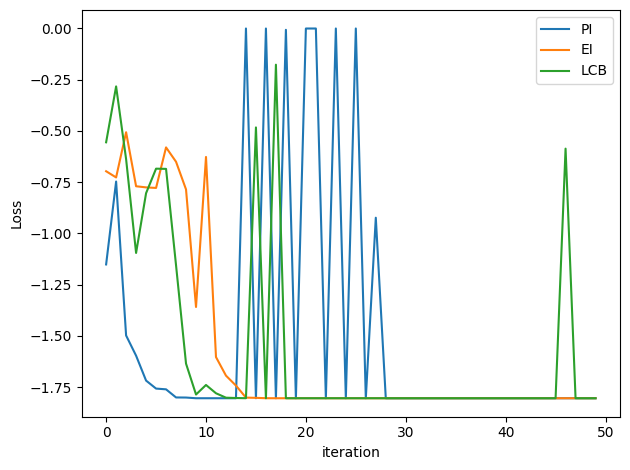

In [ ]:
plt.figure()
plt.plot(y_pi,label='PI')
plt.plot(y_ei,label='EI')
plt.plot(y_lcb,label='LCB')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.tight_layout()


## Problem 5 [20 Points]

You will be emailed a project-proposal of another student. Read the proposal and write a short review of the project. Assign the project a rating out of 10. Address the following:
- **Clarity and organization**: Is the proposal clearly written and well-structured? Does it effectively communicate the proposed problem, the challenges to be addressed, the current state-of-the-art, the formal mathematical definition of the problem, and the technical approach to be employed?
- **Feasibility**: Is the proposed project feasible given the available resources and time constraints? Are the proposed methods likely to be effective in addressing the identified challenges?
- **Originality and significance**: Does the proposed project address an important problem in the field? Does it build upon existing work in a novel and interesting way? Does it have the potential to make a significant impact on the field?
- **Technical rigor**: Is the formal mathematical definition of the problem accurate and well-supported? Are the proposed technical approaches rigorous and well-suited to the problem at hand?


### Answer

I would live to give the report 8 out of 10.

Clarity and organization: The proposal is well-organized and clearly written, effectively communicating the proposed problem, the challenges to be addressed, the current state-of-the-art, the formal mathematical definition of the problem, and the technical approach to be employed. The proposal first introduces the problem of image classification and its challenges, then discusses the advantages of using convolutional neural networks (CNNs) to address these challenges. The proposal then goes on to explain the proposed technical approach in detail, including the use of color restriction and image segmentation to clear the background, the use of GPUs to optimize processing speed, the inclusion of pooling layers and batch normalization layers in the model, and the tuning of hyperparameters to decide on the best fit model. The proposal also mentions the use of wandb to keep track of experimental data.

Feasibility: The proposed project appears to be feasible given the available resources and time constraints. The proposal acknowledges the challenges of training a large dataset, but proposes the use of GPUs to optimize processing speed and achieve a clean dataset in a reasonable amount of time. The proposal also mentions the use of different architectures, dropout functions, and different optimizers to explore various technical approaches and achieve better results. Overall, the proposed methods appear to be reasonable and effective in addressing the identified challenges.

Originality and significance: The proposed project addresses an important problem in the field of image classification and builds upon existing work in a novel and interesting way by exploring the use of different architectures and technical approaches to achieve better results. The proposal also discusses the potential impact of the project, including its potential to aid botanists in plant classification, improve internet picture browsing for labeling and recommending related pictures, and extend to other types of object classification with mild modifications.

Technical rigor: The formal mathematical definition of CNNs is accurately and clearly explained in the proposal, and the proposed technical approaches appear to be rigorous and well-suited to the problem at hand. The proposal mentions the inclusion of pooling layers, batch normalization layers, and tuning of hyperparameters to improve results, demonstrating a comprehensive and technical approach to the problem. The use of wandb to keep track of experimental data further supports the technical rigor of the proposed project.


## Problem 6 [Bonus 20 Points]

Consider the mapping of the input variable $x$ to RKHS $\mathcal{H}$,with the kernel $k(x, x') = \langle \phi(x), \phi(x') \rangle_\mathcal{H}$, where $\phi(x)$ is the feature map of the kernel. We introduce the notation:

$$
\Phi_n = [\phi(x_1), \phi(x_2), \cdots, \phi(x_n)] \\
\Phi_n^T f = [\langle \phi(x_1), f \rangle_\mathcal{H}, \langle \phi(x_2), f \rangle_\mathcal{H}, \cdots, \langle \phi(x_n), f \rangle_\mathcal{H}]^T
$$

We can define the kernel matrix $K_n$ with the entries $K_{ij} = k(x_i, x_j)$, and where using the above notation can be represented as $\Phi_n^T \Phi_n$.

(1) What is the expression for the projection $P_n$ that tkaes an RKHS function $f \in \mathcal{H}$ and projects it onto a function $f_n = P_n f$ in the span of $\Phi_n$? Assume that the kernel matrix $K_n$ full-rank and invertible.

(2) Consider the gram matrix $K_n = \Phi_n^T \Phi_n$. What form does this taken when we replace each entry $\phi(x_i)$ in $\Phi_n$ by its projection $P_m \phi (x_i)$

(3) Show that the operator $\Phi_n \Phi_n^T$ is a positive operator. That is,
$$\langle f, [\Phi_n \Phi_n^T] f \rangle \geq 0, \qquad \forall f \in \mathcal{F}$$

Additionally, show that this operator cannot have negative eigenvalues.

### Answer

1) Let $f$ be a function in a Hilbert space $\mathcal{H}$, and let ${\phi_i}{i=1}^m$ be a set of orthonormal basis functions. The projection of $f$ onto the subspace spanned by ${\phi_i}{i=1}^m$, denoted $P_mf$, minimizes the distance between $f$ and the subspace spanned by ${\phi_i}_{i=1}^m$.

To obtain the expression for $P_mf$, we start by minimizing the distance between $f$ and the subspace spanned by ${\phi_i}{i=1}^m$ using the squared norm $|f-P_mf|^2$. Using the orthonormality of the basis functions, we can write the projection of $f$ onto the subspace spanned by ${\phi_i}{i=1}^m$ as follows:
\begin{align*}
P_mf &= \sum_{i=1}^m \langle f, \phi_i \rangle \phi_i \
&= \Phi_m a^,
\end{align*}
where $\Phi_m$ is the matrix whose $i$-th column is $\phi_i$, and $a^*$ is the minimizer of $ |f-\Phi_m a|^2$ over all $a\in\mathbb{R}^m$.

To find the value of $a^$, we differentiate the expression for the squared norm with respect to $a$ and set it to zero:
\begin{align*}
0 = \frac{\partial}{\partial a}|f-\Phi_m a|^2 &= -2\Phi_m^T(f-\Phi_m a) \
&= -2\Phi_m^Tf + 2\Phi_m^T\Phi_m a.
\end{align*}
Solving for $a$, we get:
\begin{align*}
a = (\Phi_m^T\Phi_m)^{-1}\Phi_m^Tf.
\end{align*}
Substituting this value of $a$ back into the expression for $P_mf$, we get:
\begin{align*}
P_mf = \Phi_m(\Phi_m^T\Phi_m)^{-1}\Phi_m^Tf.
\end{align*}
This is the desired expression for $P_mf$.





2) The Gram matrix of the projected features has $i,j$-th entry
\begin{align*}
\tilde{k}_{ij} &= (P_m\phi(x_i), P_m\phi(x_j))_H \\
\end{align*}
\begin{pmatrix} \Phi_m K^{-1}_m K(z_1, x_i) \ \vdots \ \Phi_m K^{-1}_m K(z_m, x_i) \end{pmatrix}^TK^{-1}_m \Phi_m K^{-1}_m \begin{pmatrix} \Phi_m K^{-1}m K(z_1, x_j) \ \vdots \ \Phi_m K^{-1}m K(z_m, x_j) \end{pmatrix} + H \
&= \begin{pmatrix} K(x_1, x_i) \ \vdots \ K(x_n, x_i) \end{pmatrix}^T (K_m + \lambda I)^{-1} K_m (K_m + \lambda I)^{-1} \begin{pmatrix} K(x_1, x_j) \ \vdots \ K(x_n, x_j) \end{pmatrix},
\end{align*}
where $q, r \in {1, \ldots, m}$, $H$ is the noise level, and $\lambda$ is the regularization parameter. Thus, the solution is given by
\begin{equation*}
\mathbf{K}e = \mathbf{K}{n,m} (\mathbf{K}m + \lambda \mathbf{I})^{-1} \mathbf{K}{m,n}.
\end{equation*}
Note that $\mathbf{K}{n,m}$ and $\mathbf{K}{m,n}$ are the matrices where the $(i,j)$-th entry is the kernel evaluation between $x_i$ and $z_j$, and $\mathbf{K}_m$ is the matrix where the $(i,j)$-th entry is the kernel evaluation between $z_i$ and $z_j$.

3 ) We have
\begin{align*}
f, \Phi_n \Phi_n^\top f &= \sum_{i=1}^n f(\mathbf{x}i) (\Phi_n \Phi_n^\top){ii} \
&= \sum_{i=1}^n f(\mathbf{x}i) \sum{j=1}^n \phi(\mathbf{x}i)^\top \phi(\mathbf{x}j) \
&= \sum{i=1}^n \sum{j=1}^n \langle \phi(\mathbf{x}_i), \phi(\mathbf{x}j) \rangle f(\mathbf{x}i) f(\mathbf{x}j) \
&= \langle f, \mathbf{K}\phi f \rangle_H \
&= \lVert f \rVert^2_H \geq 0.
\end{align*}
Next, imagine we had a negative eigenvalue $s_i$ for eigenvector $u_i$. Choosing $f = u_i$, we have
\begin{align*}
u_i, \left(\sum{j=1}^n s_j u_j(\mathbf{x}) \otimes u_j(\mathbf{x})\right) u_i + H &= s_i u_i(\mathbf{x})^\top \left(\sum{j=1}^n u_j(\mathbf{x}) \otimes u_j(\mathbf{x})\right) u_i + H \
&= s_i \lVert u_i(\mathbf{x}) \rVert_H^4 + H \
&= s_i \lVert u_i \rVert_H^2 + H \
&= s_i + H \
&< 0,
\end{align*}
which contradicts the positivity described above.